# Predicting Morgate Loan Approval

### Group 9

## Import libraries

In [1]:
import pandas as pd #data frames (for storing data)
import numpy as np #scientific computing
import itertools
import seaborn as sns

#matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick #for percentage ticks
import scikitplot as skplt 

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split #Data split function
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import r2_score

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier #Decision Tree algorithm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder #OneHotEncoding

from sklearn.preprocessing import scale 
from sklearn.linear_model import Lasso, LassoCV #LASSO
from sklearn.metrics import mean_squared_error

from collections import Counter
import random

-----
## 1. Load the Data

In [2]:
label_data = pd.read_csv("train_labels.csv")
label_prev = label_data.head()
values_data = pd.read_csv("train_values.csv") 
values_prev = values_data.head()
#print(values_prev)
#print(label_prev)

data = pd.merge(values_data, label_data, on='row_id')
data.head(10).style

,row_id,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval,msa_md,state_code,county_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,ffiecmedian_family_income,tract_to_msa_md_income_pct,number_of_owner-occupied_units,number_of_1_to_4_family_units,lender,co_applicant,accepted
0,0,3,1,1,1,70,3,18,37,246,2,5,1,24.000000,6203.000000,44.230000,60588.000000,50.933000,716.000000,2642.000000,4536,False,1
1,1,1,1,3,1,178,3,369,52,299,1,5,1,57.000000,5774.000000,15.905000,54821.000000,100.000000,1622.000000,2108.000000,2458,False,0
2,2,2,1,3,1,163,3,16,10,306,2,5,1,67.000000,6094.000000,61.270000,67719.000000,100.000000,760.000000,1048.000000,5710,False,1
3,3,1,1,1,1,155,1,305,47,180,2,5,1,105.000000,6667.000000,6.246000,78439.000000,100.000000,2025.000000,2299.000000,5888,True,1
4,4,1,1,1,1,305,3,24,37,20,2,3,2,71.000000,6732.000000,100.000000,63075.000000,82.200000,1464.000000,1847.000000,289,False,1
5,5,1,1,3,1,133,3,221,13,55,2,5,2,51.000000,6078.000000,4.821000,82745.000000,96.550000,1827.000000,2340.000000,964,False,1
6,6,3,1,1,1,240,3,374,28,131,1,5,2,104.000000,6068.000000,26.427000,65282.000000,81.068000,1863.000000,2560.000000,5488,False,1
7,7,2,1,1,1,210,3,322,37,35,1,5,1,55.000000,6030.000000,78.153000,108353.000000,59.439000,969.000000,1601.000000,2442,True,1
8,8,1,1,3,2,209,3,24,37,20,2,5,1,244.000000,5151.000000,88.156000,63414.000000,62.813000,411.000000,481.000000,2118,True,1
9,9,1,1,3,1,197,3,194,9,20,2,5,1,86.000000,7916.000000,24.893000,65927.000000,100.000000,1861.000000,2123.000000,3507,False,0


--------
## 2. Data Exploration

* Here we perform some exploratory data analysis (EDA) to better understand the structure, variable types and values in the dataset.
* Our target variable (=label) here is `accepted` [0 = not accepted, 1 = accepted]


### a) Check the shape of the dataset


In [3]:
#data.shape

### b) Exploratory data analysis (EDA)

* We run a short EDA and observe:
* some obviously redundant variables (e.g. row_id)
* However, there are **missing values** as -1 in columns `state_code`, `msa_md` and `county_code` indicates for a missing value. Some other columns also have null values. We will treat the missing values depending on the data types.

In [4]:
#data.describe().style

In [5]:
#data.info()

### c) Correlation matrix

In [6]:
#corr=data.corr()
#plt.figure(figsize = (30,30))
#sns.heatmap(corr, annot=True)

### d) Data Description

In [7]:
#data.describe().round()

### e) Converting the Bool Type into int

In [8]:
data['co_applicant'] = data['co_applicant'].astype(int)        # Transform boolean to integer
pd.set_option('display.max_columns', None)
#data.head() #Check that the change was succesful

### g) Drop Features

In [9]:
data = data.drop(['row_id', 'msa_md', 'ffiecmedian_family_income', 'tract_to_msa_md_income_pct', 'lender', 'county_code', 
                 'number_of_1_to_4_family_units','number_of_owner-occupied_units'], axis=1)


We got rid of some irrelevant columns: 
- `msa_m` and `county_code` which indicates property location (we keep only the `state_code` information)
- lenders as we don't have background information and too many variables  
- `ffiecmedian_family_incom` and `tract_to_msa_md_income_pct` because they're related to `msa_m`
- `number_of_1_to_4_family_unit` and `number_of_owner-occupied_units` because they were highly correlated with `population`. For the correlation matrix, we assume a threshold of 0.7

### h) change column name

In [10]:
data = data.rename(columns={'preapproval': 'preapproval_request'})

### i) Create new columns

In [11]:
data['missing_state_code'] = np.where(data['state_code']== -1, 1, 0)

In [12]:
data['missing_population'] = np.where(pd.isnull(data['population']), 1, 0)

In [13]:
data['missing_applicant_income'] = np.where(pd.isnull(data['applicant_income']), 1, 0) 

In [14]:
data['missing_minority_population_pct'] = np.where(pd.isnull(data['minority_population_pct']), 1, 0) 

In [15]:
data.describe()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval_request,state_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,co_applicant,accepted,missing_state_code,missing_population,missing_applicant_income,missing_minority_population_pct
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,460052.000000,477535.000000,477534.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,1.366276,1.047650,2.066810,1.109590,221.753158,2.764722,23.726924,2.036228,4.786586,1.462374,102.389521,5416.833956,31.617310,0.400052,0.500228,0.038264,0.044930,0.079896,0.044932
std,0.690555,0.231404,0.948371,0.326092,590.641648,0.543061,15.982768,0.511351,1.024927,0.677685,153.534496,2728.144999,26.333938,0.489909,0.500000,0.191833,0.207151,0.271132,0.207155
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,0.534000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,93.000000,3.000000,6.000000,2.000000,5.000000,1.000000,47.000000,3744.000000,10.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,2.000000,1.000000,162.000000,3.000000,26.000000,2.000000,5.000000,1.000000,74.000000,4975.000000,22.901000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2.000000,1.000000,3.000000,1.000000,266.000000,3.000000,37.000000,2.000000,5.000000,2.000000,117.000000,6467.000000,46.020000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,3.000000,3.000000,3.000000,100878.000000,3.000000,52.000000,4.000000,7.000000,4.000000,10139.000000,37097.000000,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### j) Replace null values

***REMEMBER TO DOUBLE-CHECK THIS PART***

- We will replace null values in `applicant_income` with median value of each category that belongs to `applicant_race`
- Create a new column that describes the applicant income level in respect to loan amount


In [16]:
# The applicant_income column has some null values which we will replace with the column median
#data['applicant_income'] = data['applicant_income'].fillna(data['applicant_income'].median())

#dict = data.groupby('accepted')['applicant_income'].median().to_dict()
data['applicant_income'].fillna(value = data['applicant_income'].median(), inplace = True)


data['income_loan_ratio'] = data['applicant_income']/ data['loan_amount']
#data.head() #Check if the change was succesful

In [17]:
#After creating a new column that describes the applicant income level,
#we drop the redundant variables that were used in the ratio.

#data = data.drop(['applicant_income', 'loan_amount' ], axis=1)

Next we examine the census information about the state_code

In [18]:
#sns.catplot(data=data, x="state_code", y="minority_population_pct", height=10, aspect=2)

In [19]:
#sns.catplot(data=data, x="state_code", y="population", height=10, aspect=2)

In [20]:
#sns.catplot(data=data, x="state_code", y="number_of_owner-occupied_units", height=10, aspect=2)

In [21]:
#sns.catplot(data=data, x="state_code", y="number_of_1_to_4_family_units", height=10, aspect=2)

Based on the graphs below, we see that there are no information about 
* `number_of_1_to_4_family_units`
* `number_of_owner-occupied_units`
* `population`
* `minority_population_pct` 
in relation to the missing state_code (-1)

Therefore, we will drop all rows where state_code is missing

In [22]:
#data = data[data.state_code != -1]

In [23]:
data.shape

(500000, 20)

Then we fill the missing census information with the median value of the state_code group

In [24]:
data.loc[data['state_code']  == -1, 'minority_population_pct'] = data.loc[data['state_code']  == -1, 'minority_population_pct'].fillna(value=data['minority_population_pct'].median())

In [25]:
data.loc[data['state_code']  == -1, 'population'] = data.loc[data['state_code']  == -1, 'population'].fillna(value=data['population'].median())

In [26]:
dict = data.groupby('state_code')['population'].median().to_dict()

data['population'].fillna(data['state_code'].map(dict), inplace = True)

In [27]:
dict = data.groupby('state_code')['minority_population_pct'].median().to_dict()

data['minority_population_pct'].fillna(data['state_code'].map(dict), inplace = True)

In [28]:
#dict = data.groupby('state_code')['number_of_owner-occupied_units'].median().to_dict()

#data['number_of_owner-occupied_units'].fillna(data['state_code'].map(dict), inplace = True)

In [29]:
#dict = data.groupby('state_code')['number_of_1_to_4_family_units'].median().to_dict()

#data['number_of_1_to_4_family_units'].fillna(data['state_code'].map(dict), inplace = True)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Data columns (total 20 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   loan_type                        500000 non-null  int64  
 1   property_type                    500000 non-null  int64  
 2   loan_purpose                     500000 non-null  int64  
 3   occupancy                        500000 non-null  int64  
 4   loan_amount                      500000 non-null  int64  
 5   preapproval_request              500000 non-null  int64  
 6   state_code                       500000 non-null  int64  
 7   applicant_ethnicity              500000 non-null  int64  
 8   applicant_race                   500000 non-null  int64  
 9   applicant_sex                    500000 non-null  int64  
 10  applicant_income                 500000 non-null  float64
 11  population                       500000 non-null  float64
 12  mi

In [31]:
data.describe()

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval_request,state_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,co_applicant,accepted,missing_state_code,missing_population,missing_applicant_income,missing_minority_population_pct,income_loan_ratio
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.00000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,1.366276,1.047650,2.066810,1.109590,221.753158,2.764722,23.726924,2.036228,4.786586,1.462374,100.121312,5397.552844,31.23473,0.400052,0.500228,0.038264,0.044930,0.079896,0.044932,1.135305
std,0.690555,0.231404,0.948371,0.326092,590.641648,0.543061,15.982768,0.511351,1.024927,0.677685,147.474440,2667.993806,25.82037,0.489909,0.500000,0.191833,0.207151,0.271132,0.207155,5.235876
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,14.000000,0.53400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000513
25%,1.000000,1.000000,1.000000,1.000000,93.000000,3.000000,6.000000,2.000000,5.000000,1.000000,49.000000,3805.000000,11.11000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000
50%,1.000000,1.000000,2.000000,1.000000,162.000000,3.000000,26.000000,2.000000,5.000000,1.000000,74.000000,4975.000000,22.90100,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.441176
75%,2.000000,1.000000,3.000000,1.000000,266.000000,3.000000,37.000000,2.000000,5.000000,2.000000,112.000000,6379.000000,44.55125,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.733945
max,4.000000,3.000000,3.000000,3.000000,100878.000000,3.000000,52.000000,4.000000,7.000000,4.000000,10139.000000,37097.000000,100.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1237.375000


In [32]:
data

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval_request,state_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,co_applicant,accepted,missing_state_code,missing_population,missing_applicant_income,missing_minority_population_pct,income_loan_ratio
0,3,1,1,1,70,3,37,2,5,1,24.0,6203.0,44.230,0,1,0,0,0,0,0.342857
1,1,1,3,1,178,3,52,1,5,1,57.0,5774.0,15.905,0,0,0,0,0,0,0.320225
2,2,1,3,1,163,3,10,2,5,1,67.0,6094.0,61.270,0,1,0,0,0,0,0.411043
3,1,1,1,1,155,1,47,2,5,1,105.0,6667.0,6.246,1,1,0,0,0,0,0.677419
4,1,1,1,1,305,3,37,2,3,2,71.0,6732.0,100.000,0,1,0,0,0,0,0.232787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,1,1,1,2,150,1,-1,2,2,1,87.0,4975.0,22.901,1,0,1,1,0,1,0.580000
499996,1,1,1,1,140,3,47,2,5,1,216.0,3452.0,6.887,1,0,0,0,0,0,1.542857
499997,1,2,1,1,22,3,46,3,3,1,35.0,2925.0,36.046,0,0,0,0,0,0,1.590909
499998,1,1,2,1,35,3,6,1,5,1,41.0,3442.0,98.879,0,0,0,0,0,0,1.171429


----
## 3. Descriptive analytics

### Proportion of accepted and non-accepted cases

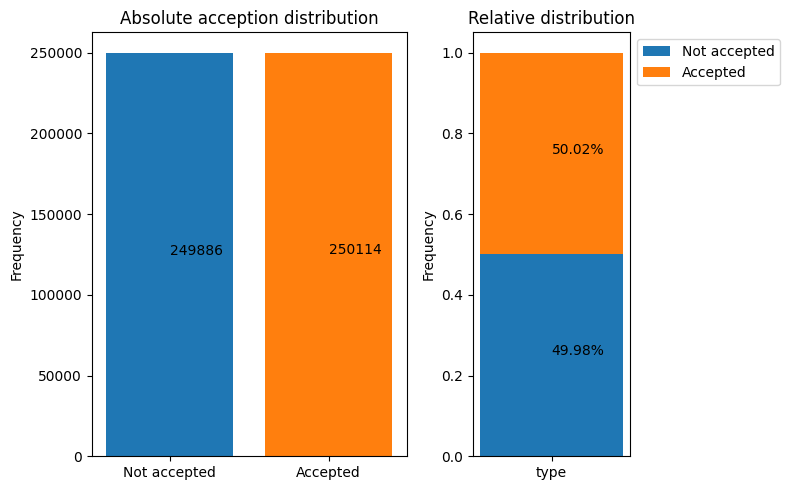

In [33]:
keys, counts = np.unique(data.accepted, return_counts=True)
counts_norm = counts/counts.sum()
fig = plt.figure(figsize=(8, 5)) #specify figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1]) #specify relative size of left and right plot

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['Not accepted', 'Accepted'], counts, color=['#1f77b4','#ff7f0e']) #left bar plot
ax0 = plt.title('Absolute acception distribution') 
ax0 = plt.ylabel('Frequency')
ax0 = plt.text(keys[0], counts[0]/2, counts[0]) #add text box with count of non-fraudulent cases
ax0 = plt.text(keys[1], counts[1]/2, counts[1]) #add text box with count of fraudulent cases

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['type'], [counts_norm[0]], label='Not accepted')
ax1 = plt.bar(['type'], [counts_norm[1]], bottom=counts_norm[0], label='Accepted')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Relative distribution')
ax1 = plt.ylabel('Frequency')
ax1 = plt.text(['type'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(2)))
ax1 = plt.text(['type'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(2)))

plt.tight_layout()
plt.show()

### Accepted Type By Loan Purpose

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_52184/3699437216.py:15: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax2 = data.groupby(['loan_purpose','accepted'])['accepted'].size().groupby(level=0).apply(


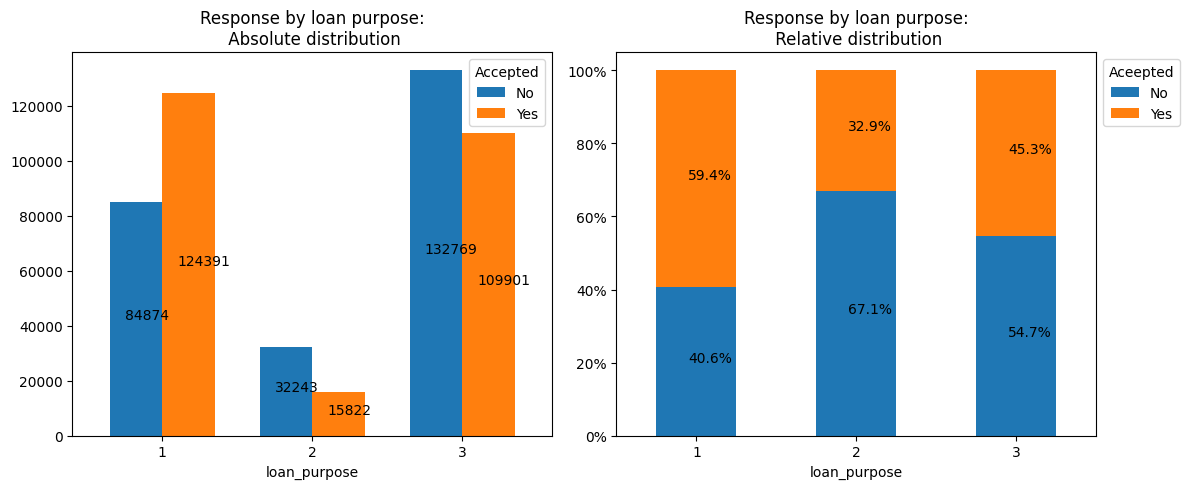

In [34]:
#Accepted type by Loan Purpose 
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['loan_purpose', 'accepted'])['accepted'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by loan purpose:\n Absolute distribution') 
ax1.legend(["No", "Yes"], title= "Accepted")
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['loan_purpose','accepted'])['accepted'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["No", "Yes"], title="Aceepted", bbox_to_anchor=(1, 1))
plt.title('Response by loan purpose:\n Relative distribution') 

#plot bar labels
for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

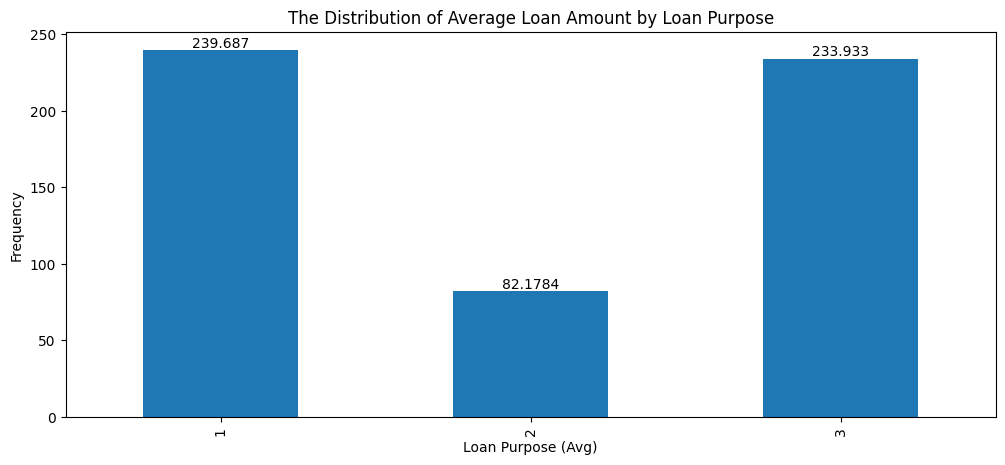

In [35]:
fig = plt.figure(figsize=(12, 5))
ax=data.groupby('loan_purpose')['loan_amount'].mean().plot.bar()
plt.title("The Distribution of Average Loan Amount by Loan Purpose")
plt.ylabel("Frequency")
plt.xlabel('Loan Purpose (Avg)')
for container in ax.containers:
    ax.bar_label(container)


We observe that the loan purpose of home improvement (2) has the lowest acceptance rate compared to home purchase (1) and refinancing (3). Moreover, home purchase loan purpose has the highest acceptance rate.

### The Distribution of Loan Amount

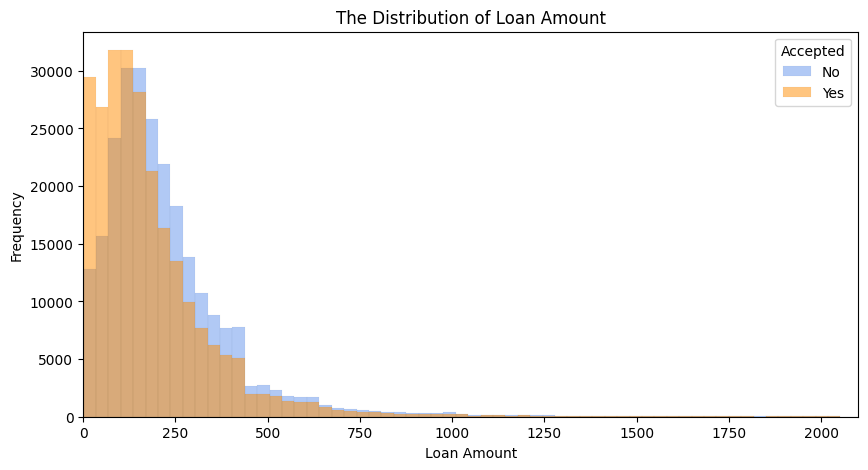

In [36]:
plt.figure(figsize=(10,5))
df=data[['loan_amount', 'accepted']]
ax=sns.histplot(data=df, x='loan_amount', hue='accepted', bins=3000, palette=["darkorange", "cornflowerblue"])
ax=plt.title("The Distribution of Loan Amount")
ax=plt.xlabel("Loan Amount")
ax=plt.ylabel("Frequency")
plt.xlim(left=0, right=2100)
ax=plt.legend(["No", "Yes"], title="Accepted")
plt.show()

It seems that higher loan amounts get rejected more than lover loan amounts.

From the graph above, we observe that the loan amount feature is highly right skewed. Therefore, the feature needs to be processed before the modelling. https://reinec.medium.com/my-notes-handling-skewed-data-5984de303725

/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  

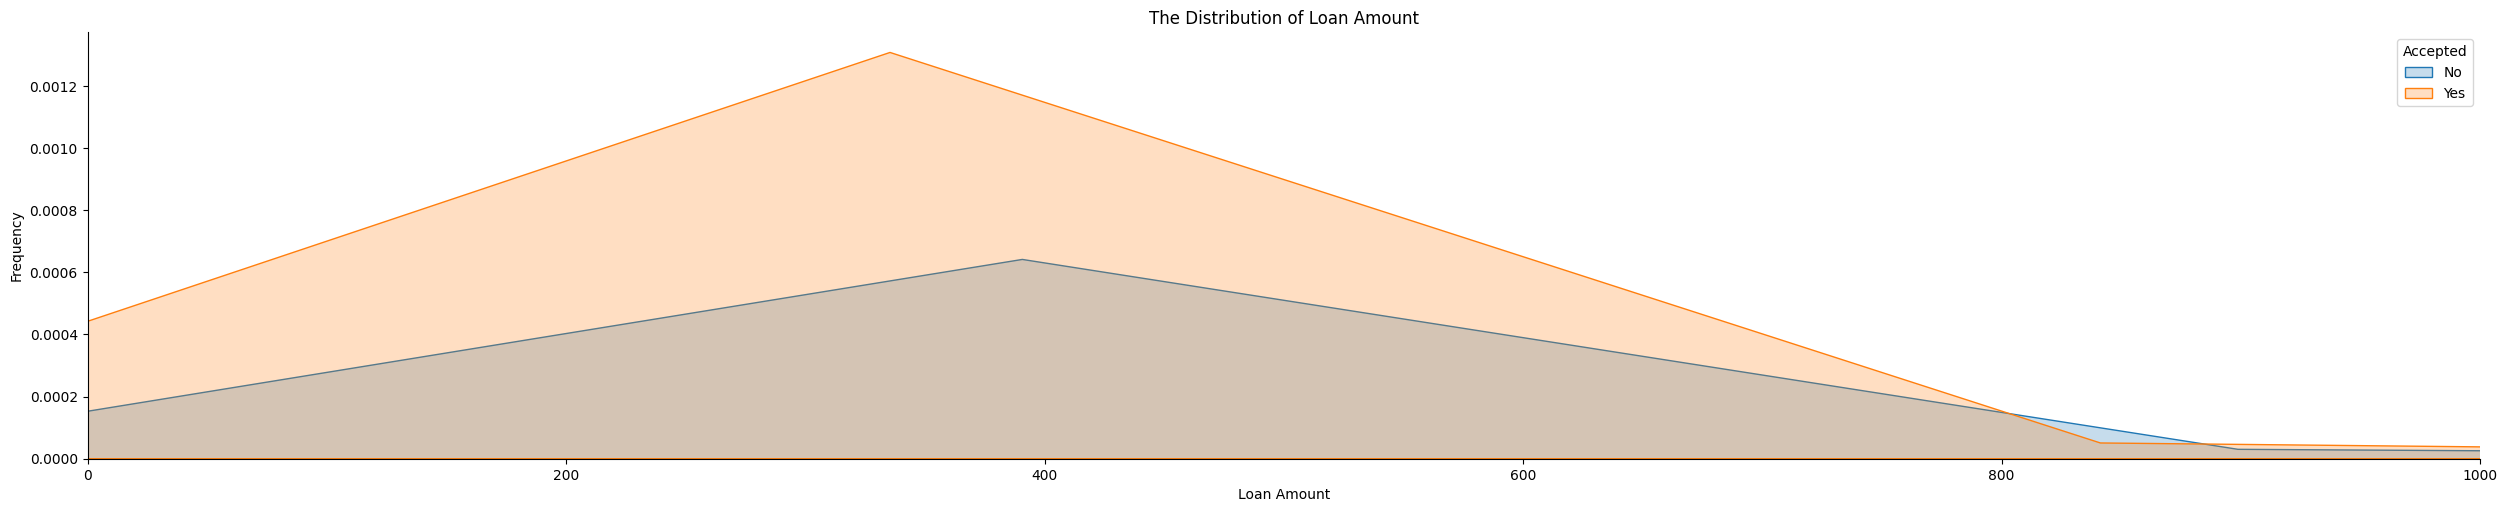

In [37]:
ax = sns.FacetGrid(data,hue='accepted',height=5, aspect=5)
ax.map(sns.kdeplot,'loan_amount',shade=True)
#ax.set(xlim=(0,data['applicant_income'].max()))
ax=plt.legend(["No", "Yes"], title="Accepted", bbox_to_anchor=(1, 1))
ax=plt.title("The Distribution of Loan Amount")
ax=plt.ylabel("Frequency")
ax=plt.xlabel('Loan Amount')

plt.xlim(0,1000)
plt.show()

From the graph above, we observe that low loan amount have a higher probability of getting accepted. After exceeding the 800$, the probability gets even between getting accepted or rejected.

### The Distribution of Applicant Income

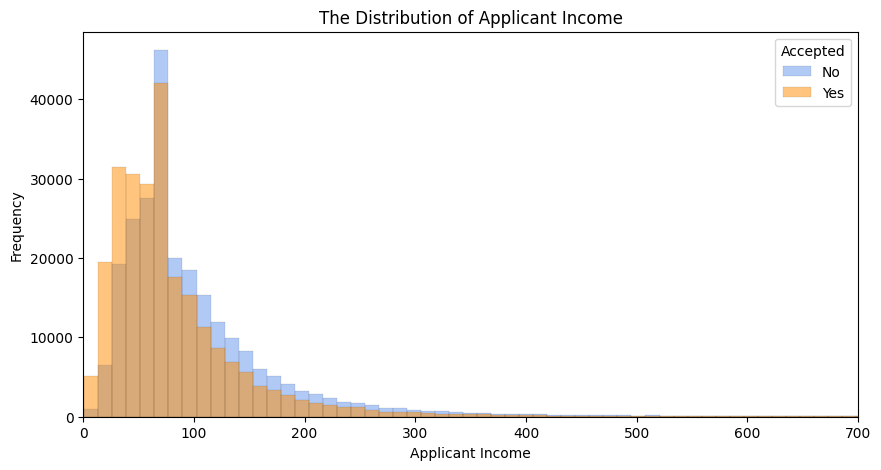

In [38]:
plt.figure(figsize=(10,5))
df=data[['applicant_income', 'accepted']]
ax=sns.histplot(data=df, x='applicant_income', hue='accepted', bins=800, palette=["darkorange", "cornflowerblue"])
ax=plt.title("The Distribution of Applicant Income")
ax=plt.xlabel("Applicant Income")
ax=plt.ylabel("Frequency")
plt.xlim(left=0, right=700)
ax=plt.legend(["No", "Yes"], title="Accepted")
plt.show()

From the graph above, we observe that the applicant income feature is highly right skewed. Therefore, the feature needs to be processed before the modelling. https://reinec.medium.com/my-notes-handling-skewed-data-5984de303725

/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(*plot_args, **plot_kwargs)
/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/Users/xin/opt/anaconda3/envs/py/lib/python3.10/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  

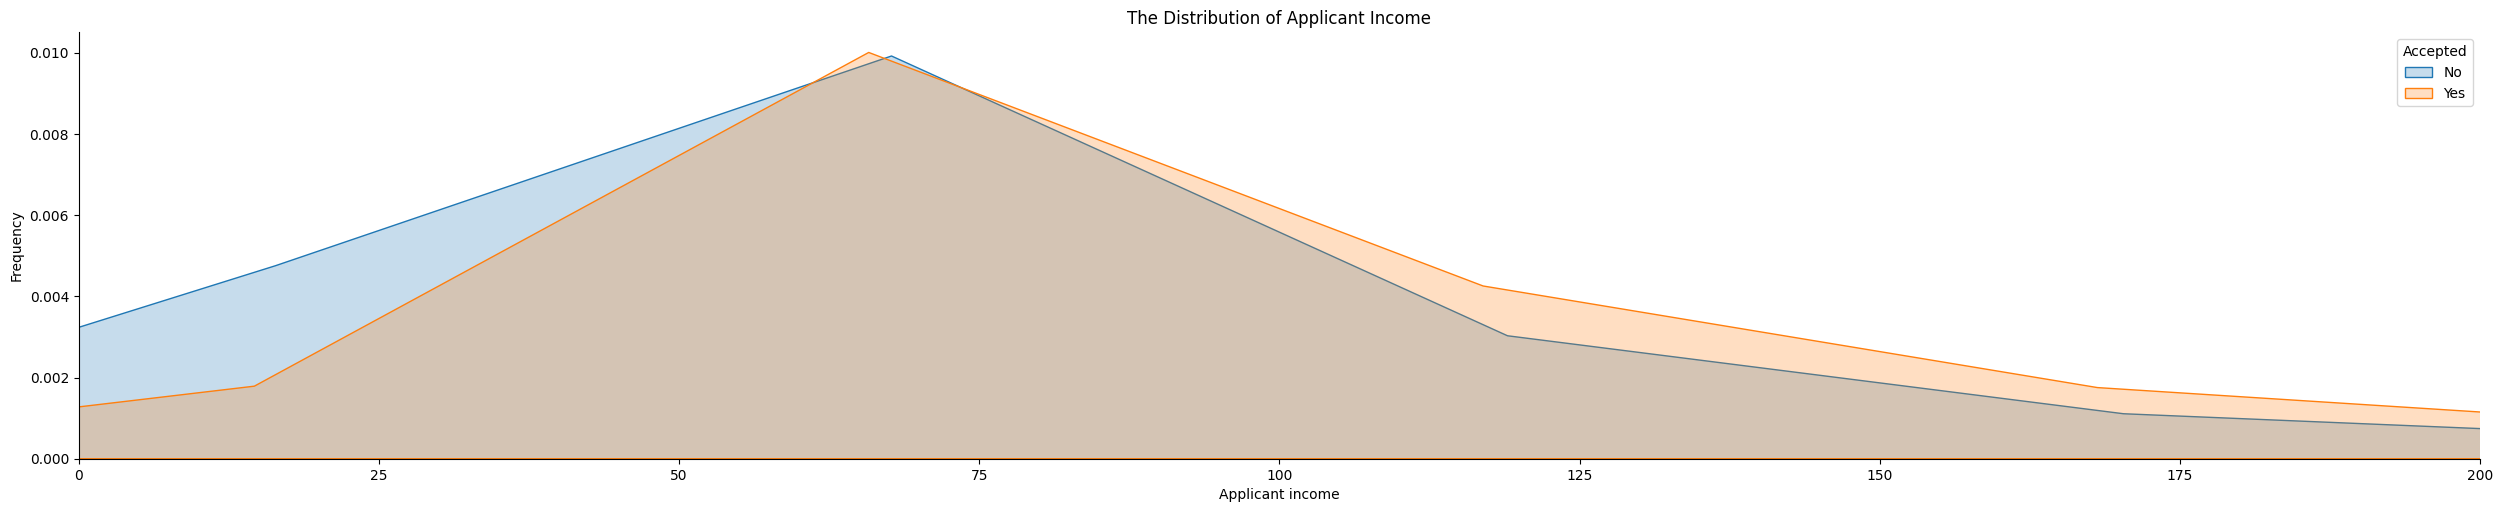

In [39]:
#income plot
ax = sns.FacetGrid(data,hue='accepted',height=5, aspect=5)
ax.map(sns.kdeplot,'applicant_income',shade=True)
ax=plt.legend(["No", "Yes"], title="Accepted", bbox_to_anchor=(1, 1))
ax=plt.title("The Distribution of Applicant Income")
ax=plt.ylabel("Frequency")
ax=plt.xlabel('Applicant income')

plt.xlim(0,200)
plt.show()

From the graph above, we observe that low applicant income have a higher probability of getting rejected. 

### The distribution of loan amounts in relation to the applican income

From the distribution of loan amounts and the distribution of applicant income, we see that higher loan amounts get rejected more and applicants with higher income get rejected more. Therefore, we create a distribution of loan amounts in relation to the applicant's income.

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_52184/1047235450.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['relative_loan_amount'] = (df['loan_amount'] / df['applicant_income'])


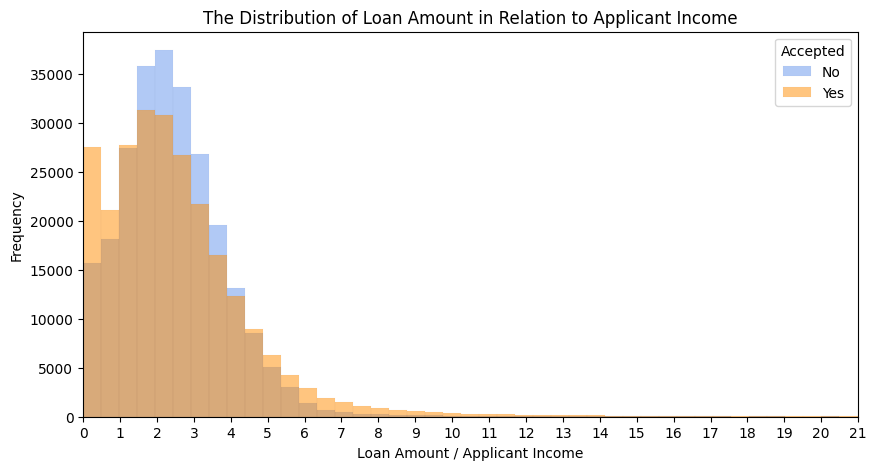

In [40]:
plt.figure(figsize=(10,5))


# Creating a dataframe with relative loan amount
df=data[['loan_amount', 'applicant_income', 'accepted']]
df['relative_loan_amount'] = (df['loan_amount'] / df['applicant_income'])

ax=sns.histplot(data=df, x='relative_loan_amount', hue='accepted', bins = 4000, palette=["darkorange", "cornflowerblue"])
ax=plt.title("The Distribution of Loan Amount in Relation to Applicant Income")
ax=plt.xlabel("Loan Amount / Applicant Income")
ax=plt.ylabel("Frequency")
plt.xlim(left=0, right=21)
ax=plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
ax=plt.legend(["No", "Yes"], title="Accepted")
plt.show()

From the distribution of loan amount in relation to the applicant income, we see that, on average, loan amounts that are higher than the applicant’s yearly income get rejected more

### Property Type

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_52184/3101039893.py:20: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax2 = data.groupby(['property_type','accepted'])['accepted'].size().groupby(level=0).apply(


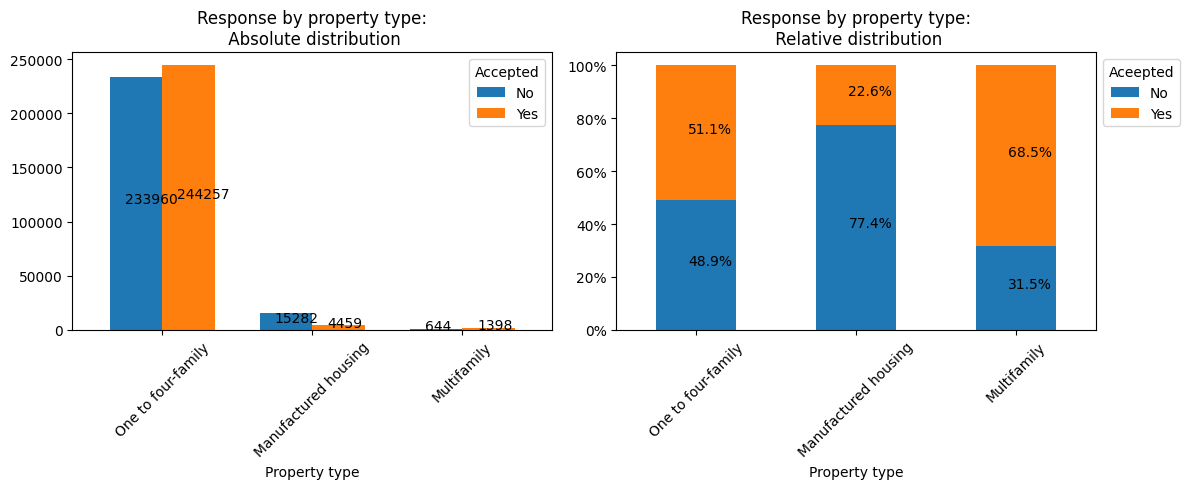

In [41]:
#Accepted type by Property Type 
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Property types
property_types = ['One to four-family', 'Manufactured housing', 'Multifamily']

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['property_type', 'accepted'])['accepted'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by property type:\n Absolute distribution') 
ax1.legend(["No", "Yes"], title= "Accepted")
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))
plt.xlabel('Property type')
ax1.set_xticklabels(property_types, rotation = 45)

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['property_type','accepted'])['accepted'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["No", "Yes"], title="Aceepted", bbox_to_anchor=(1, 1))
plt.title('Response by property type:\n Relative distribution') 
plt.xlabel('Property type')
ax2.set_xticklabels(property_types, rotation = 45)

#plot bar labels
for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

The abobe graph shows us that there are a lot 1-5 family housing types. 

### Occupancy

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_52184/2204362107.py:20: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax2 = data.groupby(['occupancy','accepted'])['accepted'].size().groupby(level=0).apply(


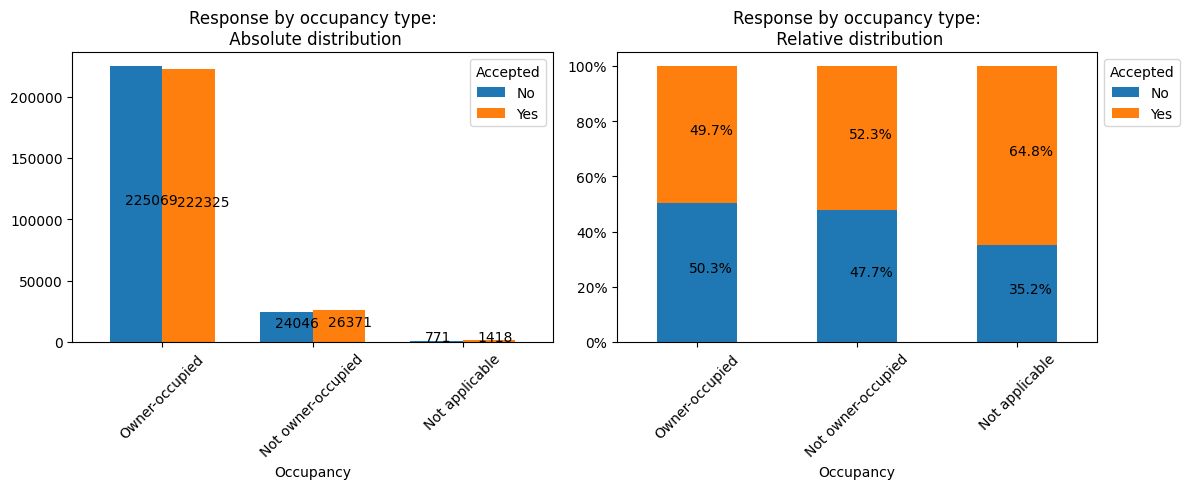

In [42]:
#Accepted type by Occupancy 
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Occupancies
occupancy = ['Owner-occupied', 'Not owner-occupied', 'Not applicable']

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['occupancy', 'accepted'])['accepted'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by occupancy type:\n Absolute distribution') 
ax1.legend(["No", "Yes"], title= "Accepted")
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))
plt.xlabel('Occupancy')
ax1.set_xticklabels(occupancy, rotation = 45)

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['occupancy','accepted'])['accepted'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["No", "Yes"], title="Accepted", bbox_to_anchor=(1, 1))
plt.title('Response by occupancy type:\n Relative distribution')
plt.xlabel('Occupancy')
ax2.set_xticklabels(occupancy, rotation = 45)

#plot bar labels
for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

We observe a rather even relative distribution, however, occupancy of a principal dwelling is the most frequent occupancy type.

### Applicant ethnicity and race

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_52184/3315107383.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax2 = data.groupby(['applicant_ethnicity','accepted'])['accepted'].size().groupby(level=0).apply(


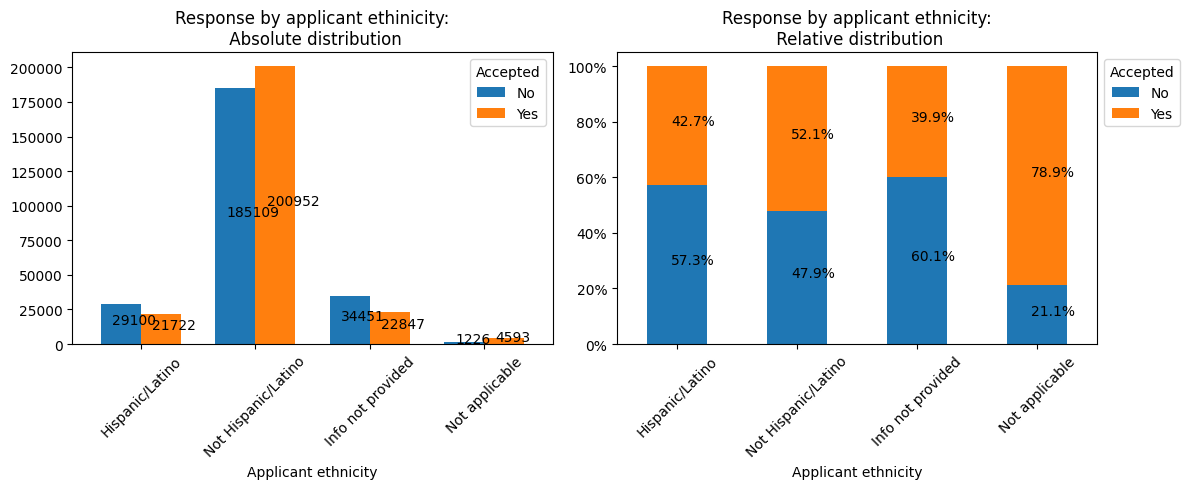

In [43]:
#Accepted type by applicant ethnicity 
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Ethnicities
ethnicity = ['Hispanic/Latino', 'Not Hispanic/Latino', 'Info not provided', 'Not applicable']

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['applicant_ethnicity', 'accepted'])['accepted'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by applicant ethinicity:\n Absolute distribution') 
ax1.legend(["No", "Yes"], title= "Accepted")
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))
plt.xlabel('Applicant ethnicity')
ax1.set_xticklabels(ethnicity, rotation = 45)


#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['applicant_ethnicity','accepted'])['accepted'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["No", "Yes"], title="Accepted", bbox_to_anchor=(1, 1))
plt.title('Response by applicant ethnicity:\n Relative distribution') 
plt.xlabel('Applicant ethnicity')
ax2.set_xticklabels(ethnicity, rotation = 45)

#plot bar labels
for p, q in zip(ax2.patches[0:4], ax2.patches[4:8]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_52184/492440350.py:21: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax2 = data.groupby(['applicant_race', 'accepted'])['accepted'].size().groupby(level=0).apply(


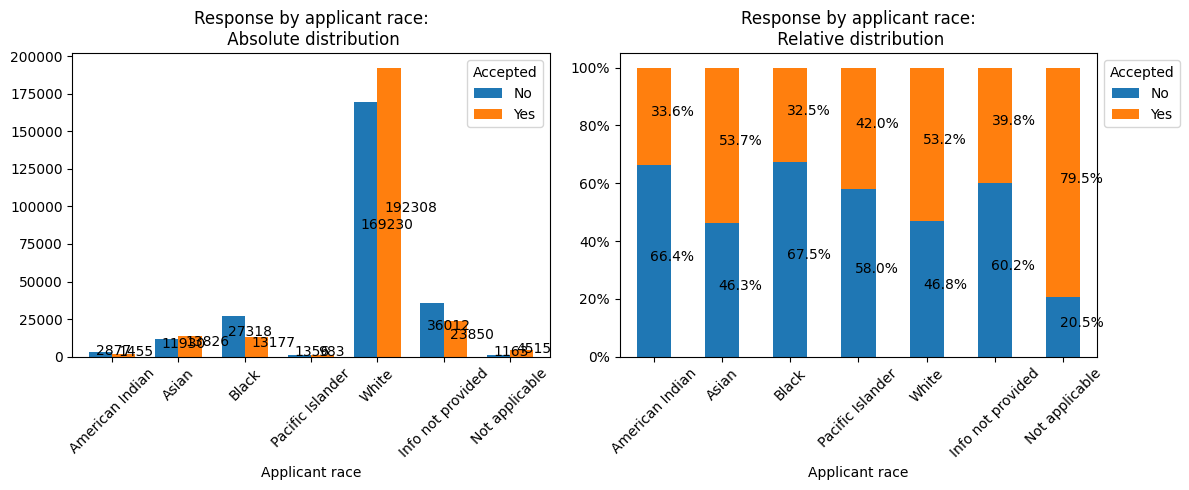

In [44]:
#Accepted type by applicant race 
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Races
races = ['American Indian', 'Asian', 'Black', 'Pacific Islander', 'White', 'Info not provided', 'Not applicable']

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['applicant_race', 'accepted'])['accepted'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by applicant race:\n Absolute distribution') 
ax1.legend(["No", "Yes"], title= "Accepted")
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))
plt.xlabel('Applicant race')
ax1.set_xticklabels(races, rotation = 45)


#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['applicant_race', 'accepted'])['accepted'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["No", "Yes"], title="Accepted", bbox_to_anchor=(1, 1))
plt.title('Response by applicant race:\n Relative distribution')
plt.xlabel('Applicant race')
ax2.set_xticklabels(races, rotation = 45)

#plot bar labels
for p, q in zip(ax2.patches[0:7], ax2.patches[7:14]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

We observe that black or african american as well as american indian applicants have a higher probability of getting their loan applications rejected.

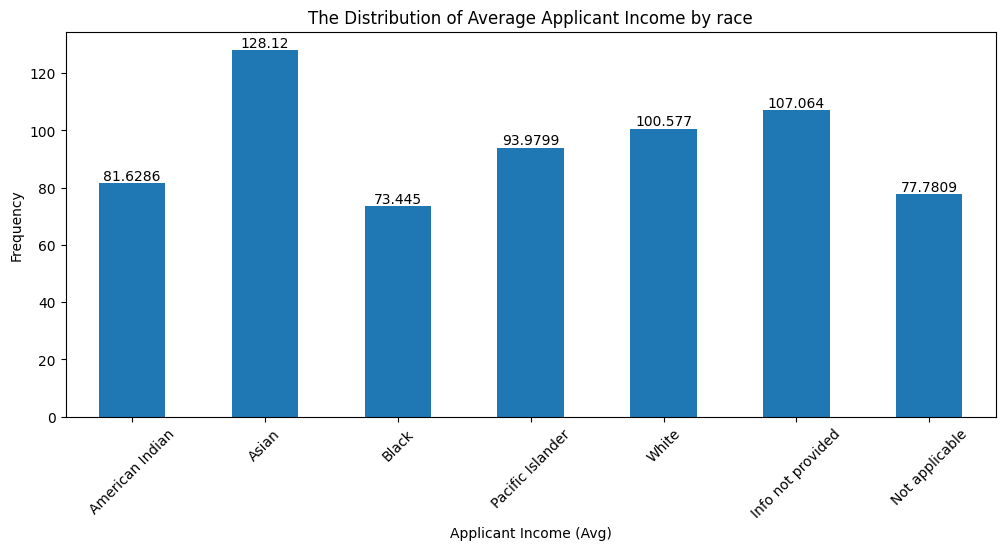

In [45]:
fig = plt.figure(figsize=(12, 5))
ax=data.groupby('applicant_race')['applicant_income'].mean().plot.bar()
plt.title("The Distribution of Average Applicant Income by race")
plt.ylabel("Frequency")
plt.xlabel('Applicant Income (Avg)')
ax.set_xticklabels(races, rotation = 45)

for container in ax.containers:
    ax.bar_label(container)

In [46]:
data.groupby("applicant_race")[["applicant_income", "loan_amount"]].mean()

,applicant_income,loan_amount
applicant_race,,
1,81.628578,159.352493
2,128.119856,323.970026
3,73.444993,156.833831
4,93.979906,238.723814
5,100.577259,204.473461
6,107.064097,223.529050
7,77.780909,1343.238640


We observe that on average, the ones who have a higher probability of getting their loan applications rejected have a lower average income. 

### Applicant sex 

In [47]:
freq_per=data['applicant_sex'].value_counts(normalize=True) * 100
sex = ['Male', 'Female', 'Info not provided', 'Not applicable']
freq_per.index = sex
print(freq_per.map("{:,.2f}%".format))

Male                 63.16%
Female               28.58%
Info not provided     7.13%
Not applicable        1.14%
Name: applicant_sex, dtype: object


Most of the applicants are male (63%)

### Accepted Type by Co-applicant

/var/folders/6_/32t0th512j792mqtn7dgp1kh0000gn/T/ipykernel_52184/1335317952.py:17: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax2 = data.groupby(['co_applicant','accepted'])['accepted'].size().groupby(level=0).apply(


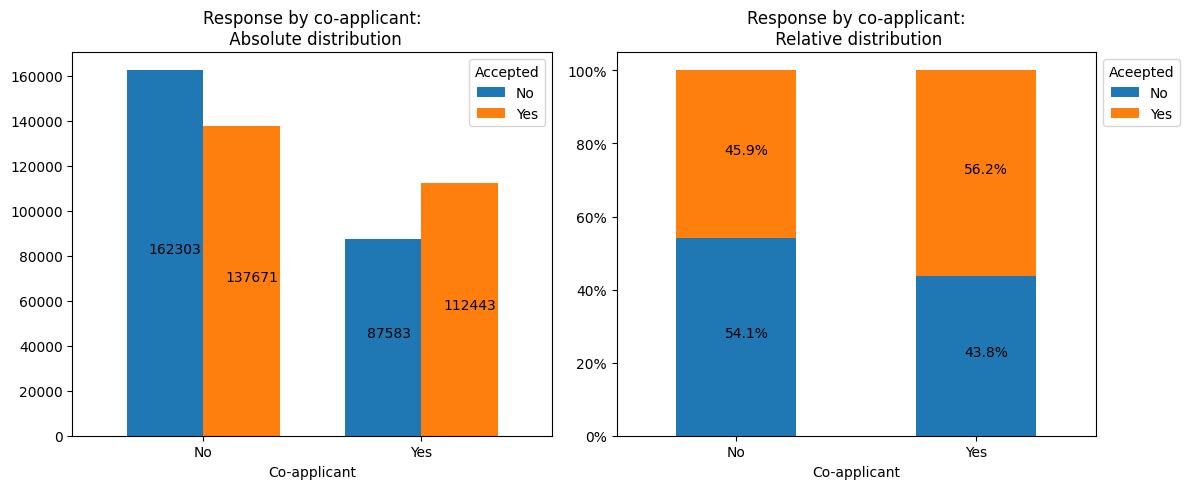

In [48]:
#Accepted type by Co-applicant  
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['co_applicant', 'accepted'])['accepted'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('Response by co-applicant:\n Absolute distribution') 
ax1.legend(["No", "Yes"], title= "Accepted")
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() + 0.1, p.get_height()/2))
ax1.set_xticklabels(['No', 'Yes'])
ax1.set_xlabel('Co-applicant')

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['co_applicant','accepted'])['accepted'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(["No", "Yes"], title="Aceepted", bbox_to_anchor=(1, 1))
plt.title('Response by co-applicant:\n Relative distribution') 
ax2.set_xticklabels(['No', 'Yes'])
ax2.set_xlabel('Co-applicant')

#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.2, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.2, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

We observe that those who do not have a co-applicant have a lower probability of getting their loan applicaitons accepted.

-----
## 3. Data Preprocessing

### a) Feature Selection

In [49]:
X, y = data.loc[:, data.columns != 'accepted'], data['accepted']
X.head(10)

,loan_type,property_type,loan_purpose,occupancy,loan_amount,preapproval_request,state_code,applicant_ethnicity,applicant_race,applicant_sex,applicant_income,population,minority_population_pct,co_applicant,missing_state_code,missing_population,missing_applicant_income,missing_minority_population_pct,income_loan_ratio
0,3,1,1,1,70,3,37,2,5,1,24.0,6203.0,44.230,0,0,0,0,0,0.342857
1,1,1,3,1,178,3,52,1,5,1,57.0,5774.0,15.905,0,0,0,0,0,0.320225
2,2,1,3,1,163,3,10,2,5,1,67.0,6094.0,61.270,0,0,0,0,0,0.411043
3,1,1,1,1,155,1,47,2,5,1,105.0,6667.0,6.246,1,0,0,0,0,0.677419
4,1,1,1,1,305,3,37,2,3,2,71.0,6732.0,100.000,0,0,0,0,0,0.232787
5,1,1,3,1,133,3,13,2,5,2,51.0,6078.0,4.821,0,0,0,0,0,0.383459
6,3,1,1,1,240,3,28,1,5,2,104.0,6068.0,26.427,0,0,0,0,0,0.433333
7,2,1,1,1,210,3,37,1,5,1,55.0,6030.0,78.153,1,0,0,0,0,0.261905
8,1,1,3,2,209,3,37,2,5,1,244.0,5151.0,88.156,1,0,0,0,0,1.167464
9,1,1,3,1,197,3,9,2,5,1,86.0,7916.0,24.893,0,0,0,0,0,0.436548


In [50]:
#X=X.drop(['state_code'], axis=1)

### One-hot-encoding

We turn these categorical variables into dummy variables
* `loan_type`
* `property_type`
* `loan_purpose`
* `occupancy`
* `preapproval_request`
* `applicant_ethnicity`
* `applicant_race`
* `applicant_sex`
* `state_code`    



In [51]:
X = pd.get_dummies(X, columns=["loan_type", "property_type", "loan_purpose", 
                               "occupancy", "preapproval_request", "applicant_ethnicity",
                               "applicant_race", "applicant_sex", "state_code"], prefix=["loan_type", "property_type", "loan_purpose", 
                               "occupancy", "preapproval_request", "applicant_ethnicity",
                               "applicant_race", "applicant_sex","state_code"], drop_first=True)
X.head()

KeyError: "['state_code'] not in index"

In [ ]:
X.info()

We split the data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123456) #split data 70:30

In [ ]:
alphas = 0.01**np.linspace(10,-2,100)*0.5
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train.astype(float)), y_train)
    coefs.append(lasso.coef_)

In [ ]:
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
print('\nTraining MSE: ' + str(round(mean_squared_error(y_train, lasso.predict(X_train)), 0)))
print('\nTest MSE:    ' + str(round(mean_squared_error(y_test, lasso.predict(X_test)), 0)))

In [ ]:
# Some of the coefficients are now reduced to exactly zero.
predictors = pd.Series(lasso.coef_, index=X.columns)
pre_df=predictors.to_frame()
pd.set_option('display.max_rows', pre_df.shape[0]+1)
print(pre_df)

We visualize the split to ensure that the distribution of accepted and not accepted applications remain the same.

In [ ]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)

fig, ax = plt.subplots()

ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='Not accepted')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='Accepted')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
ax.set_xlabel('Proportion')
ax.set_ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

The distribution of accepted and not accepted applications is equal to the whole data set. It is also balanced so we do not have to balance the data. 

----
## 4. Model building

### a) Decision tree

We fit the classifier to the data. 

In [ ]:
#Define Decision tree classifier with some default parameters
dt = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3)

#Fit the training data 
dt.fit(X_train, y_train) 

We make predictions by using the unseen test data X_test.

In [ ]:
#Use classifier to predict labels
y_pred_dt = dt.predict(X_test)

#Probabilities for decision tree
y_pred_proba_dt = dt.predict_proba(X_test)


#Decision tree plot
import pydotplus
from IPython.display import Image 

# Create DOT data
dot_data = tree.export_graphviz(dt, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=['Not accept', 'Accept'], filled=True) #or use y_train.unique()

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

print ("Accuracy is: ", (accuracy_score(y_test, y_pred_dt)*100).round(2))


In [ ]:
importances = dt.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

plt.rcParams["figure.figsize"] = (20,3)
plt.figure
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

 ### b) Logistic Regression


In [ ]:
#define Logistic Regression classifier
lg = LogisticRegression(max_iter = 1000)

#Fit the training data 
lr =lg.fit(X_train, y_train)  

#Use classifier to predict labels
y_pred_lr = lr.predict(X_test)

#Probabilities for logistic regression
y_pred_proba_lr = lr.predict_proba(X_test)

print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr)*100).round(2))


#c) Light GBM

In [ ]:
#import lightgbm as ltb

In [ ]:
#lightgbm = ltb.LGBMClassifier()

In [ ]:
#light =lightgbm.fit(X_train, y_train)  

#Use classifier to predict labels
#y_pred_light = light.predict(X_test)

#Probabilities for logistic regression
#y_pred_proba_light = light.predict_proba(X_test)

#print ("Accuracy is: ", (accuracy_score(y_test, y_pred_lr)*100).round(2))


### c) Random forest

In [ ]:
rf=RandomForestClassifier(max_depth = 3, random_state =100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_proba_rf = rf.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_rf)*100).round(2))

### d) XGBoost

In [ ]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(X_train, y_train)
y_pred_xg = xg.predict(X_test)

#Probabilities for logistic regression
y_pred_proba_xg = xg.predict_proba(X_test)

print ("Accuracy is: ", (accuracy_score(y_test, y_pred_xg)*100).round(2))


### e) CatBoost

In [ ]:
pip install catboost

In [ ]:
from catboost import CatBoostClassifier


cat = CatBoostClassifier()
cat.fit(X_train, y_train)
y_pred_cat = cat.predict(X_test)

#Probabilities for logistic regression
y_pred_proba_cat = cat.predict_proba(X_test)

print ("Accuracy is: ", (accuracy_score(y_test, y_pred_cat)*100).round(2))

## 5. Model evaluation

### a) Confusion matrix

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_names = ['Not accept', 'Accept']

# Decision tree confusion matrix
cnf_matrix_dt= confusion_matrix(y_test, y_pred_dt)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_dt, classes=class_names,
                      title='Confusion matrix decision tree, without normalization')
# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_dt, classes=class_names, normalize=True,
                      title='Normalized confusion matrix decision tree')

plt.show()


# Logistic regression confusion matrix
cnf_matrix_lr= confusion_matrix(y_test, y_pred_lr)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_lr, classes=class_names,
                      title='Confusion matrix logistic regression, without normalization')
# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_lr, classes=class_names, normalize=True,
                      title='Normalized confusion matrix logistic regression')

plt.show()

# randomforest confusion matrix
cnf_matrix_rf= confusion_matrix(y_test, y_pred_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_rf, classes=class_names,
                      title='Confusion matrix Randomforest, without normalization')
# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix Randomforest')

plt.show()
    
    

# xgboost confusion matrix
cnf_matrix_xg= confusion_matrix(y_test, y_pred_xg)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_xg, classes=class_names,
                      title='Confusion matrix XgBoost, without normalization')
# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_xg, classes=class_names, normalize=True,
                      title='Normalized confusion matrix XGBoost')

plt.show()

# catboost confusion matrix
cnf_matrix_cat= confusion_matrix(y_test, y_pred_cat)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_cat, classes=class_names,
                      title='Confusion matrix CatBoost, without normalization')
# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_cat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix CatBoost')

plt.show()
    
    

### b) AUC and ROC

In [ ]:
plt.figure(figsize=(12,10))

for test, pred, name in zip([y_test,y_test, y_test,y_test,y_test], [y_pred_proba_dt[:,1], y_pred_proba_lr[:,1], y_pred_proba_xg[:,1], y_pred_proba_cat[:,1],y_pred_proba_rf[:,1]], ['Decision Tree', 'Logistic Regression', 'CatBoost', 'XGBoost', 'Random Forest']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

### e) Tuning Parameters

In [ ]:
from sklearn.model_selection import GridSearchCV
#create the grid for models
grid_rf = {'max_depth': [3,4,5],
           'n_estimators':[100, 200, 300], 
           'min_samples_split': [2, 5, 10],
           'bootstrap': [True, False]}

#Instantiate GridSearchCV
gscv = GridSearchCV (estimator = rf, param_grid = grid_rf, scoring ='recall', cv = 3)

#fit the model
gscv.fit(X_train,y_train)

#returns the estimator with the best performance
print(gscv.best_estimator_)

#returns the best score
print(gscv.best_score_)

#returns the best parameters
print(gscv.best_params_)

In [ ]:
# RandomForest accuracy
rf = RandomForestClassifier(max_depth = 3, n_estimators=300)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

#Probabilities for Random Forest
y_pred_proba_rf = rf.predict_proba(X_test)

print ("Accuracy is: ", (accuracy_score(y_test, y_pred_rf)*100).round(2))

In [ ]:
# RndomForest confusion matrix
cnf_matrix_rf= confusion_matrix(y_test, y_pred_rf)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(13, 5))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix_rf, classes=class_names,
                      title='Confusion matrix RandomForest, without normalization')
# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix_rf, classes=class_names, normalize=True,
                      title='Normalized confusion matrix RandomForest')

plt.show()
    

In [ ]:
feature_importance = rf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

### d) Cross validation 

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from numpy import mean

In [ ]:
print(cross_val_score(rf, X, y, cv=10, scoring='recall'))


In [ ]:
print(cross_val_score(rf, X, y, cv=10, scoring='accuracy'))

### e) r2 score

In [ ]:
print(r2_score(y_test, y_pred_))